# Sets Analysis

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np

## Subset of citations

In [2]:
all_citations = pd.read_csv('../inputdata/all_cases_citations.csv')
print('Total citations relations EUR-LEX: ',len(all_citations))

Total citations relations EUR-LEX:  43780


In [3]:
sampled_cases = pd.read_csv('../inputdata/sampled_cases.csv').rename(columns={'source':'case'})
print('Total sampled cases for the study: ',len(sampled_cases))

Total sampled cases for the study:  177


In [4]:
sampled_cases.head()

,quantile,case,citations,topic
0,1.00,61990CJ0006,43,social policy
1,1.00,62003CJ0453,32,public health
2,0.99,62007CJ0378,32,social policy
3,0.98,61995CJ0261,19,social policy
4,1.00,62000CJ0465,17,data protection


---
## Functions 

In [5]:
#Creating all unique nodes of the graph (this nodes catakogue works for both graphs)
def df_to_json_nodes(df_relations, df_attributes, node_name = 'case'):
    """"Assumes the columns are called source and target"""
    nodes_list = []; nodes = pd.DataFrame()
    nodes_list.extend(list(df_relations.source.unique()))
    nodes_list.extend(list(df_relations.target.unique()))
    nodes[str(node_name)] = list(set(nodes_list))
    nodes = pd.merge(nodes, df_attributes, how='left').fillna('NA')
    nodes = nodes.set_index(str(node_name)).to_dict('index')
    return nodes

In [6]:
#Graph description
def graph_description(g):
    N_nodes, N_edges = g.order(), g.size()
    avg_deg = float(N_nodes)/N_edges
    print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes, N_edges, avg_deg) )

In [7]:
#Get the graph and layout, works only for this dataset
def graph_and_layout(df, nodes):
    #Assumes the relations are called source and target
    g = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True) #, create_using = nx.DiGraph)
    nx.set_node_attributes(g, nodes)
    return g

In [8]:
#goupings the colors
def groups(g):
    group0 = []
    group1 = []
    group2 = []
    group3 = []
    for n in g.nodes():
        if g.node[str(n)]['topic'] == "NA":
            group0.append(n)
        elif g.node[str(n)]['topic'] == "social policy":
            group1.append(n)
        elif g.node[str(n)]['topic'] == "public health":
            group2.append(n)
        elif g.node[str(n)]['topic'] == "data protection":
            group3.append(n)
        else:
            print(n)
    return group0, group1, group2, group3

In [9]:
def plot_graph(g, pos, groups, edges_groups):
    plt.figure(figsize=(16, 12))
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[0],
                           node_color="#878787", #gray
                           node_size=10,
                           linewidths = 3,
                           alpha=0.3)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[1],
                           node_color="#3f59bf", #blue "social policy"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[2],
                           node_color="#bfb71f",  #yellow "public health"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[3],
                           node_color="#3ecc0e", #green "data protection"
                           node_size=30,
                           alpha=0.8)
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[0],
                           width=0.5,alpha=0.5,edge_color='gray')
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[1],
                           width=1,alpha=0.8,edge_color='red')
    #nx.draw_networkx_edges(g,pos,width=0.5,alpha=0.5, arrows=False, arrowstyle="Arc3, rad=-0.2")
    plt.show()

---
## Citations Graph

#### Taking the subset of the whole citations files where the target OR the source is in the sample

In [10]:
all_citations['sample_in_source'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['source']]
all_citations['sample_in_target'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['target']]

In [11]:
citations_subset = all_citations[(all_citations['sample_in_source'] == 1) | (all_citations['sample_in_target'] == 1)]
citations_subset = citations_subset[['source','target']]

In [12]:
print('Total citations relations sampled from EUR-LEX: ',len(citations_subset))

Total citations relations sampled from EUR-LEX:  1174


In [13]:
citations_subset.head()

,source,target
188,62016CJ0384,61962CJ0025
286,62007CO0073,61964CO0006
334,61996CJ0416,61965CJ0061
404,61996CJ0050,61968CJ0014
535,61987CJ0187,61970CJ0009


---
#### Creating the citations graph

In [14]:
nodes = df_to_json_nodes(df_relations = citations_subset,
                         df_attributes = sampled_cases[['case','topic']])
g = graph_and_layout(citations_subset, nodes) #the df of relations again
pos = nx.spring_layout(g) #nx.kamada_kawai_layout(g2)
graph_description(g)

Nodes: 1031
Edges: 1172
Avg Degree: 0.8796928327645052


In [15]:
g_rest, g_SP, g_PH, g_DP = groups(g)

/Users/pedrohserrano/anaconda3/envs/py37/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


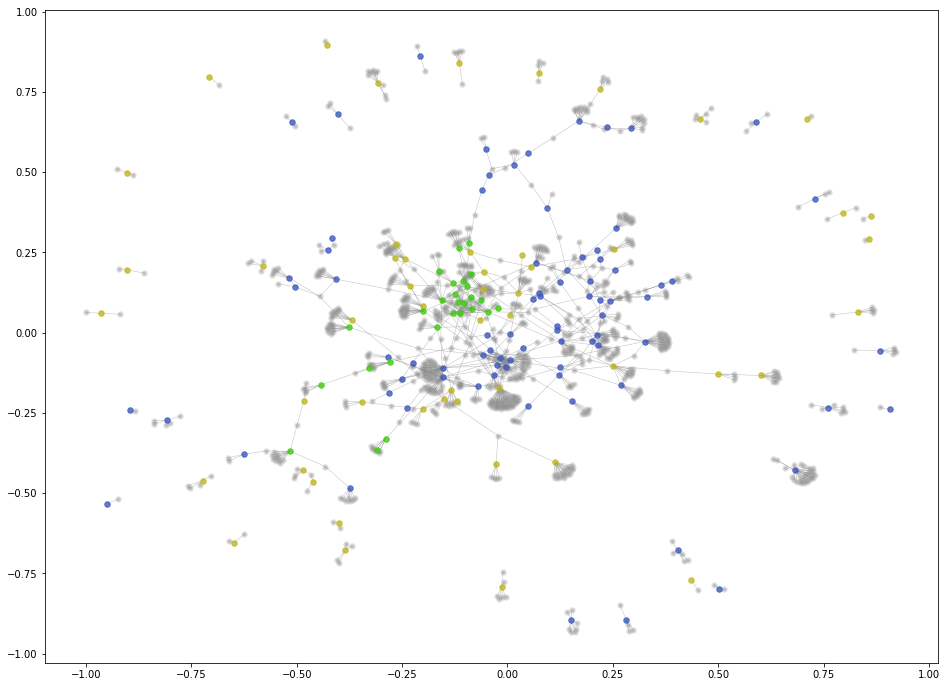

In [43]:
plot_graph(g,pos,
           [g_rest, g_SP, g_PH, g_DP],
           [[(s,t) for s, t, att in g.edges.data()],[]])

---
## Similarity Graph

In [17]:
casses_similarity = pd.read_csv('../outputdata/results.csv')
casses_similarity.head()

,source_case,similar_case,similarity_score,method,citation_link,source_case_topic
0,62003CJ0453,62006CO0421,0.727373,tfidf,True,public health
1,62003CJ0453,61984CJ0028,0.664869,tfidf,False,public health
2,62003CJ0453,61984CJ0195,0.618935,tfidf,False,public health
3,62003CJ0453,61990CJ0039,0.579735,tfidf,False,public health
4,62003CJ0453,62002CJ0145,0.566752,tfidf,False,public health


---
#### Filtering top 5 similar and the relevant algorithms

- tfidf
- doc2vec vector size = 256 (Cosine Similarity)
- Law2Vec ( Cosine Similarity)

In [18]:
#Take only the range of top 5 similar
tops5 = []; m = 12034; n = 10
for n in list(range(n, (m+1)*n, n)):
    tops5.append([i+n for i in [0,1,2,3,4]])
tops5 = [item for s in tops5 for item in s]
tops5.extend([0,1,2,3,4])

In [19]:
cases_sim_sorted = casses_similarity.sort_values(
    ['source_case','method','similarity_score'],ascending=False).reset_index()

cases_similarity_top5 = cases_sim_sorted[cases_sim_sorted.index.isin(tops5)]\
    .rename(columns = {'source_case':'source', 'similar_case':'target'})

In [20]:
cases_similarity_filtered = cases_similarity_top5[(cases_similarity_top5['method'] == 'tfidf') |
                                                (cases_similarity_top5['method'] == 'doc2vec_256')]

In [21]:
print('Total relations of cases similarity filtered from  EUR-LEX: ',len(cases_similarity_filtered))

Total relations of cases similarity filtered from  EUR-LEX:  3540


---
#### Creating the similarity graph

In [22]:
nodes2 = df_to_json_nodes(df_relations = cases_similarity_filtered,
                         df_attributes = sampled_cases[['case','topic']])
g2 = graph_and_layout(cases_similarity_filtered, nodes2) #the df of relations again
pos2 = nx.spring_layout(g2) #nx.kamada_kawai_layout(g2)
graph_description(g2)

Nodes: 2362
Edges: 3415
Avg Degree: 0.6916544655929722


In [23]:
g2_rest, g2_SP, g2_PH, g2_DP = groups(g2)

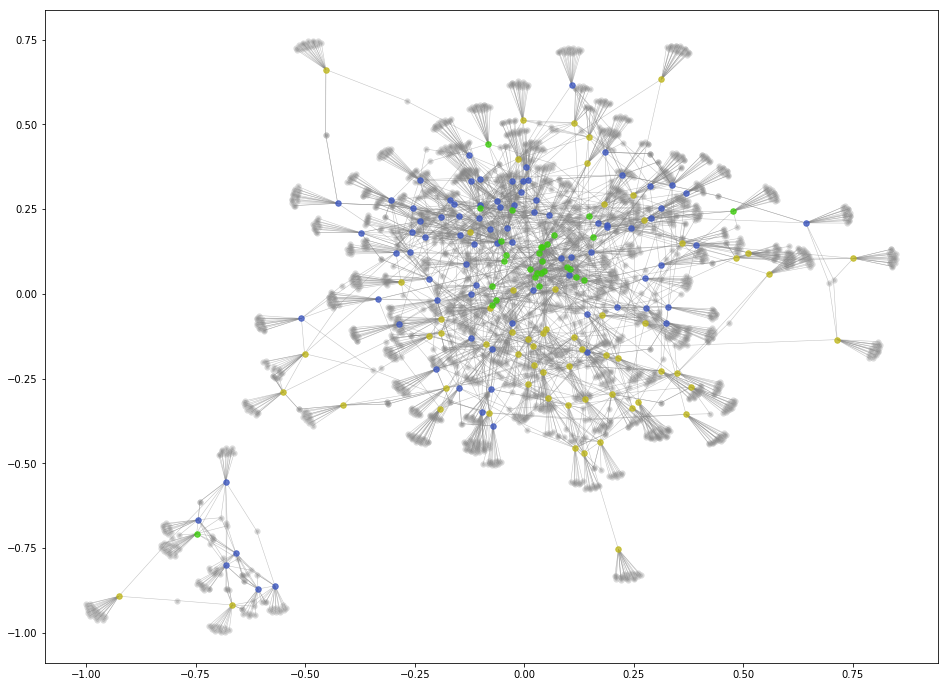

In [24]:
plot_graph(g2,pos2,
           [g2_rest, g2_SP, g2_PH, g2_DP ],
           [[(s,t) for s, t, att in g2.edges.data()],[]])

---
## Intersection Graph

In [25]:
table_cit = citations_subset[['source','target']]
table_cit.loc[:,'method'] = 'NoMethod'
table_cit.loc[:,'citation_link']= True

In [26]:
table_sim = cases_similarity_filtered[['source','target','method','citation_link']]

In [27]:
inter_table = table_sim.reset_index()\
    .append(table_cit.reset_index())\
    .reset_index().drop(columns=['level_0', 'index'])

In [28]:
inter_table.tail()

,source,target,method,citation_link
4709,62016CJ0203,62016CJ0384,NoMethod,True
4710,62016CJ0210,62013CJ0212,NoMethod,True
4711,62016CJ0210,62015CJ0182,NoMethod,True
4712,62009CJ0063,61996CJ0416,NoMethod,True
4713,62009CJ0070,61996CJ0416,NoMethod,True


---
#### Choose one method to plot

In [29]:
inter_table['method'].unique()

array(['tfidf', 'doc2vec_256', 'NoMethod'], dtype=object)

In [30]:
method = 'doc2vec_256'
method_table = inter_table[inter_table['method'] == method]

---
#### Creating the intersection graph

In [31]:
nodes3 = df_to_json_nodes(df_relations = method_table,
                         df_attributes = sampled_cases[['case','topic']])
g3 = graph_and_layout(method_table, nodes3) #the df of relations again
pos3 = nx.spring_layout(g3) #nx.kamada_kawai_layout(g2)
graph_description(g3)

Nodes: 1642
Edges: 1754
Avg Degree: 0.936145952109464


In [32]:
g3_rest, g3_SP, g3_PH, g3_DP = groups(g3)

In [33]:
edges_citation = []
edges_similarity = []
for s, t, att in g3.edges.data():
    if (att['citation_link'] == True) & (att['method'] == method):
        edges_citation.append((s,t))
    else:
        edges_similarity.append((s,t))

In [34]:
print('Percentage of links overlap: ',len(edges_citation)/len(g3.edges))

Percentage of links overlap:  0.013683010262257697


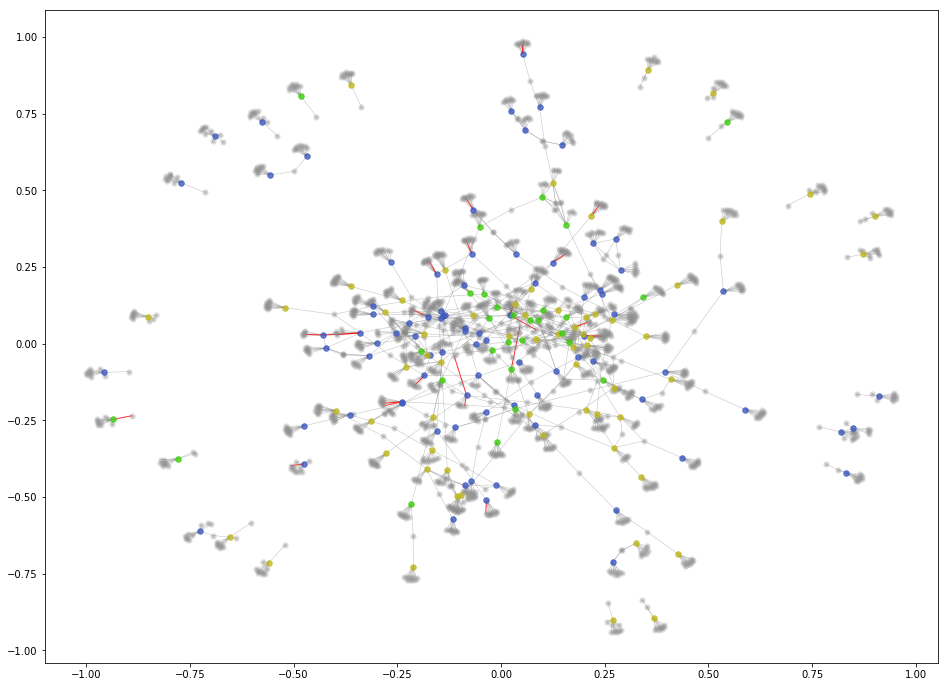

In [35]:
plot_graph(g3,pos3,
           [g3_rest, g3_SP, g3_PH, g3_DP],
           [edges_similarity,edges_citation])

---
### Summary overlap

In [36]:
base_table = inter_table[inter_table.method != 'NoMethod']

In [37]:
pd.pivot_table(inter_table[inter_table.method != 'NoMethod'],
               index='method',
               columns='citation_link',
               aggfunc='count')['source']

citation_link,False,True
method,,
doc2vec_256,1745,25
tfidf,1541,229


In [38]:
print('Overlap doc2vec_256: {} %\nOverlap tfidf: {} %'.format(
    round(100*25/1770,2),round(100*229/1770,2)))

Overlap doc2vec_256: 1.41 %
Overlap tfidf: 12.94 %


In [40]:
#plt.figure(figsize=(15, 15))
#sns.heatmap(inter_table_pivot)

In [41]:
summary_methods = inter_table\
    .groupby(['citation_link','method'])\
    .count()['target']\
    .reset_index()\
    .rename(columns={'target':'count'})\
    .sort_values('count', ascending=False)

In [42]:
summary_methods[summary_methods['citation_link']==True].head(10)

,citation_link,method,count
2,True,NoMethod,1174
4,True,tfidf,229
3,True,doc2vec_256,25
